In [1]:
from db_connect import get_connection

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Step 1: Load Data

In [2]:
table_name = input("Enter the table name: ").strip()

# This portion of the project is using the player_table

engine = get_connection()
df = pd.read_sql(f"SELECT * FROM {table_name};", con = engine)
 

In [3]:
df.head()

,role,number,player,ht,wt,yr,g,min_pct,o_rtg,poss_pct,...,diff_blk_pct,diff_stl_pct,diff_f_cper40,diff_f_dper40,diff_ft_rate,diff_ft_pct,diff_fg_2_pct,diff_fg_3_pct,transfer,prev_team
0,Major Contributor,2.0,Julian Champagnie,6-8,215.0,Jr,31.0,82.5,105.4,25.5,...,0.3,0.7,-0.3,-0.6,-8.6,-0.106,-0.014,-0.043,False,St. John's
1,Significant Contributor,0.0,Posh Alexander,6-0,200.0,So,29.0,71.8,113.4,23.2,...,0.5,-0.6,-0.8,1.3,13.8,0.016,0.052,-0.082,False,St. John's
2,Significant Contributor,5.0,Dylan Addae-Wusu,6-4,235.0,So,32.0,61.0,101.5,20.3,...,0.3,0.6,-1.7,0.1,-3.0,-0.011,-0.098,0.110,False,St. John's
3,Role Player,23.0,Montez Mathis,6-4,210.0,Sr,32.0,60.5,98.3,18.5,...,-0.7,0.5,-0.8,-0.9,-2.4,0.049,0.038,-0.033,True,Rutgers
4,Role Player,1.0,Aaron Wheeler,6-9,205.0,Sr,31.0,53.0,110.1,19.7,...,1.4,-0.7,0.1,0.8,-0.8,0.083,-0.051,0.119,True,Purdue


In [20]:
df['year'].unique()

array([2022, 2023, 2024, 2019, 2020, 2021])

In [21]:
df['player_id'].nunique()

10991

In [22]:
df['g'].unique()

array([31., 29., 32., 30., 27., 13., 11., 28., 20., 14.,  3., 21., 24.,
       23., 10., 19., 26., 16., 15.,  6.,  7., 17.,  8., 12., 25., 18.,
       36., 37., 33.,  9., 22.,  5.,  4., 35., 34., 39., 38., 40.,  2.,
        1., 41.])

# Step 2: Clean DataFrame

In [6]:
def clean_df(df):
    
    train_years = [2021, 2022, 2023]
    test_year = 2024
    
    df_hist = df[df['year'].isin(train_years)]
    player_counts = df_hist.groupby('player_id')['year'].nunique()
    players_in_all_years = player_counts[player_counts == 3].index
    
    df_three_years = df_hist[df_hist['player_id'].isin(players_in_all_years)]
    
    games_check = (df_three_years.groupby(['player_id', 'year'])['g'].min().unstack().dropna())

    players_with_10_games_each_year = games_check[(games_check >= 10).all(axis = 1)].index
    df_three_years = df_three_years[df_three_years['player_id'].isin(players_with_10_games_each_year)]
    
    same_team_players = (df_three_years.groupby('player_id')['team'].nunique().reset_index().query("team == 1")['player_id'])
    
    valid_players = same_team_players
    
    df_model = df[df['player_id'].isin(valid_players)]
    
    df_train = df_model[df_model['year'].isin(train_years)]
    
    df_2024 = df_model[df_model['year'] == test_year]
    df_2024_transfers = df_2024[df_2024['transfer'] == True]
    target_players = df_2024_transfers[df_2024_transfers['player_id'].isin(df_train['player_id'])]
    
    return df_train, target_players, valid_players

df_train, df_2024, valid_players = clean_df(df)

In [7]:
print(df_train.shape, df_2024.shape)

(2433, 74) (218, 74)


# Step 3: Split the Data & Scaling

In [8]:
def model_vars(df):
    # Outcome variable
    Y = df['o_rtg'].values

    # Covariates: prior performance
    X_cols = [
        'poss_pct', 'shots_pct', 'e_fg_pct', 'ts_pct', 'or_pct', 'dr_pct',
        'a_rate', 'to_rate', 'blk_pct', 'stl_pct', 'f_cper40', 'f_dper40',
        'ft_rate', 'ftm', 'fta', 'ft_pct', 'fgm_2', 'fga_2', 'fg_2_pct', 'fgm_3', 'fga_3',
        'fg_3_pct', 'min_pct'
    ]
    X_partial = df[X_cols].copy()

    role = pd.get_dummies(df['role'], drop_first = True)
    X = pd.concat([role, X_partial], axis = 1)

    player_names = df['player']

    return Y, X.values, player_names

In [9]:
def split_scale(df, test_size = 0.2, random_state = 42): 
    
    Y, X, player_names = model_vars(df)

    X_train, X_test, Y_train, Y_test, names_train, names_test = train_test_split(
        X, Y, player_names, test_size = test_size, random_state = random_state
    )

    scaler_x = StandardScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    
    return {
        "X_train": X_train_scaled,
        "X_test": X_test_scaled,
        "Y_train": Y_train,
        "Y_test": Y_test,
        "names_test": names_test.reset_index(drop = True),
        "scaler_x": scaler_x
    }

In [10]:
train_data_scaled = split_scale(df_train)
scaler_x = train_data_scaled["scaler_x"]

# Step 4: Stack Models

In [11]:
# Base models
base_estimators = [
    ('rf', RandomForestRegressor(n_estimators = 100, random_state = 42)),
    ('lr', LinearRegression())
]

final_estimator = Ridge(alpha = 1.0)

In [12]:
stack_model = StackingRegressor(
    estimators  =base_estimators,
    final_estimator = final_estimator,
    passthrough = False,
    cv = 5
)

In [13]:
stack_model.fit(train_data_scaled["X_train"], train_data_scaled["Y_train"])

StackingRegressor(cv=5,
                  estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('lr', LinearRegression())],
                  final_estimator=Ridge())

# Step 5: Model Results

In [14]:
y_pred = stack_model.predict(train_data_scaled["X_test"])
rmse = mean_squared_error(train_data_scaled["Y_test"], y_pred)
print(f"Stacked model RMSE: {rmse:.2f}")

Stacked model RMSE: 6.89


In [15]:
# Data for just 2024 to compare model results versus actuals 

Y_2024, X_2024, names_2024 = model_vars(df_2024)
X_2024_scaled = scaler_x.transform(X_2024)
Y_2024_pred = stack_model.predict(X_2024_scaled)

summary_2024 = pd.DataFrame({
    "player": names_2024.reset_index(drop=True),
    "Actual Offensive Rating (2024)": Y_2024,
    "Predicted If Stayed": Y_2024_pred,
    "Estimated Transfer Effect": Y_2024 - Y_2024_pred
})

In [16]:
summary_2024.sample(5)

,player,Actual Offensive Rating (2024),Predicted If Stayed,Estimated Transfer Effect
106,Isiah Warfield,105.6,104.275360,1.324640
46,Puff Johnson,120.0,118.687022,1.312978
197,Blake Preston,103.0,99.437011,3.562989
27,Javontae Hopkins,92.4,94.356170,-1.956170
154,Tylan Pope,97.3,97.424938,-0.124938


In [17]:
mse = mean_squared_error(summary_2024["Actual Offensive Rating (2024)"], summary_2024["Predicted If Stayed"])
r2 = r2_score(summary_2024["Actual Offensive Rating (2024)"], summary_2024["Predicted If Stayed"])

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.3f}")

Mean Squared Error: 11.46
R² Score: 0.905


In [23]:
# Players who improved most by transferring
summary_2024.sort_values("Estimated Transfer Effect", ascending = False).head()

,player,Actual Offensive Rating (2024),Predicted If Stayed,Estimated Transfer Effect
13,Julian Rishwain,144.7,128.485013,16.214987
52,Sean Conway,109.0,101.330217,7.669783
189,Shemar Rathan-Mayes,107.9,100.544317,7.355683
133,Andrew Taylor,124.4,117.464898,6.935102
8,Latrell Wrightsell,135.1,128.258513,6.841487


In [24]:
# Players who declined most after transferring
summary_2024.sort_values("Estimated Transfer Effect").head(5)

,player,Actual Offensive Rating (2024),Predicted If Stayed,Estimated Transfer Effect
15,Even Brauns,102.5,133.752675,-31.252675
112,Jeremiah Oden,85.5,91.623495,-6.123495
169,Javonte Johnson,101.6,107.077699,-5.477699
149,Tyler Harris,107.0,111.666957,-4.666957
55,Hunter Dickinson,111.3,115.941479,-4.641479


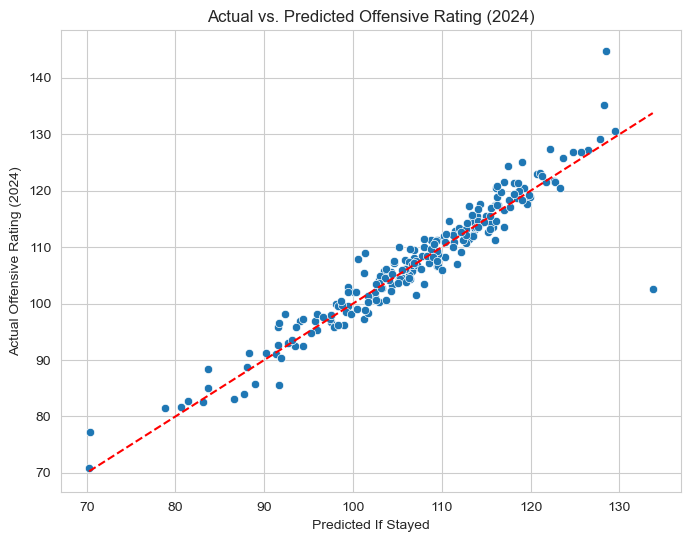

In [26]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = summary_2024, x = "Predicted If Stayed", y = "Actual Offensive Rating (2024)")
plt.plot([summary_2024["Predicted If Stayed"].min(), summary_2024["Predicted If Stayed"].max()],
         [summary_2024["Predicted If Stayed"].min(), summary_2024["Predicted If Stayed"].max()],
         color = 'red', linestyle = '--')
plt.title("Actual vs. Predicted Offensive Rating (2024)")
plt.xlabel("Predicted If Stayed")
plt.ylabel("Actual Offensive Rating (2024)")
plt.grid(True)
plt.show()

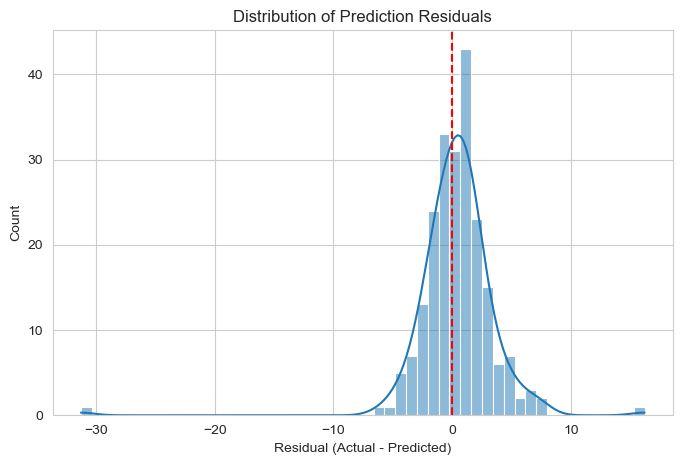

In [27]:
summary_2024["Residual"] = summary_2024["Actual Offensive Rating (2024)"] - summary_2024["Predicted If Stayed"]

plt.figure(figsize = (8, 5))
sns.histplot(summary_2024["Residual"], kde = True)
plt.axvline(0, color = 'red', linestyle = '--')
plt.title("Distribution of Prediction Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

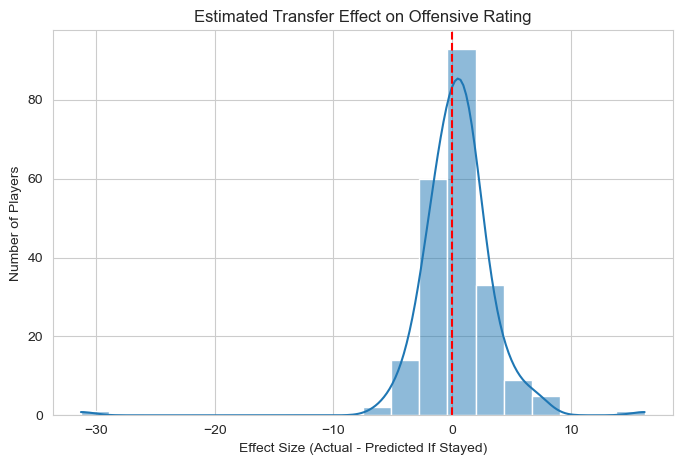

In [28]:
plt.figure(figsize = (8, 5))
sns.histplot(summary_2024["Estimated Transfer Effect"], bins = 20, kde = True)
plt.axvline(0, color = 'red', linestyle = '--')
plt.title("Estimated Transfer Effect on Offensive Rating")
plt.xlabel("Effect Size (Actual - Predicted If Stayed)")
plt.ylabel("Number of Players")
plt.show()

# Step 6: Push Data to Database

In [84]:
## This step was completed by JRS on 6/25/25. Unless the code is changed, this does not need completed again ## 

# from push_db_data import push_data_to_db
# 
# push_data_to_db(summary_2024)

Data replaced to table 'ind_player_dev_predict_2024'.
